# Phase 1: Clarification - User Requirements and Brief Generation

**Goal**: Clarify user requirements and transform them into a structured `SimulationBrief`.

This notebook implements the first phase of our MD setup workflow:

1. **User Clarification** - Determines if additional information is needed
2. **Brief Generation** - Transforms the conversation into a structured simulation brief

## Available MCP Servers

| Server | Description |
|--------|-------------|
| `structure_server` | PDB/AlphaFold/PDB-REDO retrieval, structure cleaning, ligand GAFF2 parameterization |
| `genesis_server` | Boltz-2 structure generation from FASTA sequences |
| `solvation_server` | Solvation and membrane embedding with packmol-memgen |
| `amber_server` | Amber topology (parm7) and coordinate (rst7) generation with tleap |
| `md_simulation_server` | MD simulation with OpenMM and trajectory analysis with MDTraj |

Based on `deep_research_from_scratch/notebooks/1_scoping.ipynb`


In [24]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## State and Schemas

First, we'll define the state objects and schemas for our clarification process.

The state object stores and passes context between different phases.

**Note**: We use `%%writefile` to save code to files. This allows us to reuse it in future notebooks and creates deployable code!


In [25]:
%%writefile ../src/mcp_md/state_scope.py

"""State Definitions and Pydantic Schemas for Clarification Phase.

This module defines state objects and structured schemas for the MD setup workflow
using LangGraph 1.0+ patterns:
- MessagesState for conversation tracking
- Annotated fields with proper reducers
- Pydantic models for structured outputs
"""

import operator
from typing import Annotated, Dict, List, Optional, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field


# ===== STATE DEFINITIONS (LangGraph 1.0+) =====

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input.
    
    Used as input_schema for the main graph to define the public input interface.
    """

    pass


class AgentState(MessagesState):
    """Main state for the full multi-phase MD setup system.
    
    Extends MessagesState with additional fields for MD setup coordination.
    All fields use proper reducers for state updates.
    """

    # Phase 1: Clarification
    research_brief: Optional[str] = None  # Compatibility with deep_research pattern
    simulation_brief: Optional["SimulationBrief"] = None

    # Phase 2: Setup (will be added in Notebook 2)
    setup_messages: Annotated[Sequence[BaseMessage], add_messages] = []
    decision_log: Annotated[list[dict], operator.add] = []
    outputs: dict = {}

    # Phase 3: Validation & Export (will be added in Notebook 4)
    qc_results: dict = {}
    exports: dict = {}
    final_report: str = ""


# ===== STRUCTURED OUTPUT SCHEMAS (Pydantic) =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions.
    
    Used with .with_structured_output() for LLM decision making.
    """

    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the simulation requirements.",
    )
    verification: str = Field(
        description="Verification message that we will start setup after information is provided.",
    )


class SimulationBrief(BaseModel):
    """Schema for structured simulation brief generation.
    
    Transforms conversation into structured MD setup parameters.
    Comprehensive schema covering structure preparation, solvation, and MD simulation.
    """

    # ===== STRUCTURE INPUT =====
    pdb_id: Optional[str] = Field(default=None, description="PDB ID (e.g., 1ABC)")
    fasta_sequence: Optional[str] = Field(
        default=None, description="FASTA sequence for de novo generation"
    )
    select_chains: Optional[List[str]] = Field(
        default=None, description="Chain IDs to process (e.g., ['A', 'B']). None = all chains"
    )

    # ===== LIGAND PARAMETERS =====
    ligand_smiles: Optional[Dict[str, str]] = Field(
        default=None, description="Manual SMILES for ligands: {'LIG1': 'SMILES_string'}"
    )
    charge_method: str = Field(
        default="bcc", description="Ligand charge method: 'bcc' (AM1-BCC) or 'gas' (Gasteiger)"
    )
    atom_type: str = Field(
        default="gaff2", description="Ligand atom type: 'gaff' or 'gaff2'"
    )

    # ===== STRUCTURE PREPARATION =====
    ph: float = Field(default=7.0, description="pH value for protonation")
    cap_termini: bool = Field(
        default=False, description="Add ACE/NME caps to protein termini"
    )

    # ===== SOLVATION PARAMETERS =====
    box_padding: float = Field(default=12.0, description="Box padding distance (Å)")
    cubic_box: bool = Field(
        default=True, description="Use cubic box (True) or rectangular (False)"
    )
    salt_concentration: float = Field(default=0.15, description="Salt concentration (M)")
    cation_type: str = Field(default="Na+", description="Cation type for neutralization")
    anion_type: str = Field(default="Cl-", description="Anion type for neutralization")

    # ===== MEMBRANE PARAMETERS (Advanced) =====
    is_membrane: bool = Field(
        default=False, description="Membrane system (loads lipid21 force field)"
    )
    lipids: Optional[str] = Field(
        default=None, description="Lipid composition for membrane: 'POPC', 'DOPE:DOPG', etc."
    )
    lipid_ratio: Optional[str] = Field(
        default=None, description="Lipid ratio: '3:1', '2:1//1:2', etc."
    )

    # ===== FORCE FIELD SELECTION =====
    force_field: str = Field(default="ff19SB", description="Protein force field")
    water_model: str = Field(default="tip3p", description="Water model")

    # ===== MD SIMULATION PARAMETERS =====
    temperature: float = Field(default=300.0, description="Simulation temperature (K)")
    pressure: Optional[float] = Field(
        default=1.0, description="Pressure (atm). None for NVT, value for NPT"
    )
    timestep: float = Field(default=2.0, description="Integration timestep (femtoseconds)")
    simulation_time_ns: float = Field(
        default=1.0, description="Total simulation time (nanoseconds)"
    )
    minimize_steps: int = Field(
        default=500, description="Energy minimization iterations"
    )

    # ===== MD ADVANCED SETTINGS =====
    nonbonded_cutoff: float = Field(
        default=10.0, description="Nonbonded interaction cutoff (Angstroms)"
    )
    constraints: str = Field(
        default="HBonds", description="Bond constraints: 'HBonds', 'AllBonds', or 'None'"
    )
    output_frequency_ps: float = Field(
        default=10.0, description="Trajectory frame output interval (picoseconds)"
    )

    # ===== BOLTZ-2 OPTIONS (Advanced) =====
    use_boltz2_docking: bool = Field(default=True, description="Use Boltz-2 for docking")
    use_msa: bool = Field(
        default=True, description="Use MSA server for Boltz-2 predictions"
    )
    num_models: int = Field(
        default=5, description="Number of Boltz-2 models to generate"
    )

    # ===== OUTPUT OPTIONS =====
    output_formats: List[str] = Field(default=["amber"], description="Output formats")

Overwriting ../src/mcp_md/state_scope.py


## Prompts

Define prompts for clarification and brief generation.


In [26]:
%%writefile ../src/mcp_md/prompts.py

"""Prompt templates for the MD setup system.

This module contains all prompt templates used across the workflow components.
"""

clarify_requirements_prompt = """
You are helping a user set up a molecular dynamics (MD) simulation system.

<Available_Capabilities>
Our system provides:
1. **Structure Preparation**: Fetch structures from PDB/AlphaFold/PDB-REDO, clean and repair
2. **Structure Prediction**: Generate structures from FASTA sequences using Boltz-2 AI
3. **Ligand Handling**: Parameterize ligands with GAFF2 force field (supports custom SMILES)
4. **Solvation**: Add water boxes or embed in lipid membranes
5. **MD Simulation**: Run production-ready simulations with OpenMM
6. **Analysis**: Trajectory analysis (RMSD, RMSF, hydrogen bonds, contacts, etc.)
</Available_Capabilities>

<Messages_So_Far>
{messages}
</Messages_So_Far>

Today's date is {date}.

<Your_Task>
Assess whether you need to ask clarifying questions, or if the user has provided enough information to generate a complete simulation setup plan.

**REQUIRED Information:**
- Protein structure source:
  * PDB ID (e.g., "1AKE")
  * FASTA sequence (for de novo prediction with Boltz-2)
  * Local PDB/mmCIF file path
- Ligand information (if protein-ligand complex):
  * Residue name and SMILES string (for non-PDB ligands)
  * Or ligand will be included in PDB structure

**COMMONLY NEEDED Information (ask if ambiguous):**
- Specific chains to process (for multi-chain structures)
- Simulation duration (default: 1 ns)
- Temperature (default: 300 K)
- Ensemble type: NPT (with pressure) or NVT
- System type: soluble protein in water OR membrane protein

**ADVANCED Features (ask if user mentions):**
- Membrane systems: lipid composition (POPC, DOPE, etc.)
- Boltz-2 predictions: use MSA for accuracy? how many models?
- Custom parameters: pH, salt concentration, force field, box size

<Decision>
If critical information is MISSING or AMBIGUOUS:
  {{"need_clarification": true, "question": "<specific question>", "verification": ""}}

If you have SUFFICIENT information to proceed:
  {{"need_clarification": false, "question": "", "verification": "<brief acknowledgement of what will be done>"}}
</Decision>

<Guidelines>
- Be concise and specific in questions
- Don't ask about parameters that have good defaults
- Focus on choices that significantly affect the simulation setup
- If user mentions "membrane" or "lipid", ask about lipid composition
- If user provides FASTA, ask if they want Boltz-2 prediction
- For multi-chain PDBs, ask which chains to include
</Guidelines>
"""

generate_simulation_brief_prompt = """
Extract all simulation requirements from these messages:
<Messages>
{messages}
</Messages>

Return a structured JSON with all available parameters.

**Structure Input:**
- pdb_id, fasta_sequence, select_chains
- ligand_smiles (as dict: {{"LIG1": "SMILES_string"}})

**Ligand Parameters:**
- charge_method (bcc or gas), atom_type (gaff or gaff2)

**Structure Preparation:**
- ph, cap_termini

**Solvation:**
- box_padding, cubic_box, salt_concentration, cation_type, anion_type

**Membrane (if mentioned):**
- is_membrane, lipids, lipid_ratio

**Force Fields:**
- force_field, water_model

**MD Simulation:**
- temperature, pressure (null for NVT), timestep, simulation_time_ns, minimize_steps

**MD Advanced:**
- nonbonded_cutoff, constraints, output_frequency_ps

**Boltz-2 Options:**
- use_boltz2_docking, use_msa, num_models

**Output:**
- output_formats

Use defaults for parameters not explicitly mentioned by the user.
"""

Overwriting ../src/mcp_md/prompts.py


## Clarification Agent

Now we implement the clarification workflow with two nodes:
1. `clarify_requirements` - Determines if more information is needed
2. `generate_simulation_brief` - Creates structured brief


In [27]:
%%writefile ../src/mcp_md/clarification_agent.py

"""User Clarification and Simulation Brief Generation.

This module implements the clarification phase of MD setup using LangGraph 1.0+ patterns:
- Command API for node routing
- Structured outputs with Pydantic
- MessagesState-based state management
"""

from datetime import datetime
from typing import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command

from mcp_md.prompts import (
    clarify_requirements_prompt,
    generate_simulation_brief_prompt,
)
from mcp_md.state_scope import (
    AgentInputState,
    AgentState,
    ClarifyWithUser,
    SimulationBrief,
)

def get_today_str() -> str:
    """Get current date formatted for prompts."""
    return datetime.now().strftime("%a %b %-d, %Y")

# Initialize model (LangGraph 1.0+ compatible)
# Using Anthropic Claude Haiku 4.5
model = init_chat_model(model="anthropic:claude-haiku-4-5-20251001", temperature=0.0)

# Alternative models (uncomment to use):
# Option 1: OpenAI
# model = init_chat_model(model="openai:gpt-4o", temperature=0.0)
# Option 2: Ollama (local)
# from langchain_ollama import ChatOllama
# model = ChatOllama(model="gemma2:9b", temperature=0.0)

def clarify_requirements(
    state: AgentState,
) -> Command[Literal["generate_simulation_brief", "__end__"]]:
    """Determine if sufficient information exists to proceed with MD setup.
    
    Returns:
        Command: Routes to END if clarification needed, otherwise to generate_simulation_brief
    """
    structured_model = model.with_structured_output(ClarifyWithUser)
    response = structured_model.invoke(
        [
            HumanMessage(
                content=clarify_requirements_prompt.format(
                    messages=get_buffer_string(messages=state["messages"]),
                    date=get_today_str(),
                )
            )
        ]
    )

    if response.need_clarification:
        # Need more info - return to user
        return Command(
            goto=END, update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        # Have enough info - proceed to brief generation
        return Command(
            goto="generate_simulation_brief",
            update={"messages": [AIMessage(content=response.verification)]},
        )

def generate_simulation_brief(state: AgentState) -> dict:
    """Generate structured simulation brief from conversation history.
    
    Returns:
        dict: Updated state with simulation_brief, research_brief, and setup_messages
    """
    structured_model = model.with_structured_output(SimulationBrief)
    response = structured_model.invoke(
        [
            HumanMessage(
                content=generate_simulation_brief_prompt.format(
                    messages=get_buffer_string(state.get("messages", [])),
                    date=get_today_str(),
                )
            )
        ]
    )

    return {
        "simulation_brief": response,
        "research_brief": str(response.model_dump()),
        "setup_messages": [
            HumanMessage(content=f"Starting MD setup with: {response.model_dump_json()}")
        ],
    }

# Build clarification graph (LangGraph 1.0+ pattern)
clarification_builder = StateGraph(AgentState, input_schema=AgentInputState)
clarification_builder.add_node("clarify_requirements", clarify_requirements)
clarification_builder.add_node("generate_simulation_brief", generate_simulation_brief)
clarification_builder.add_edge(START, "clarify_requirements")
clarification_builder.add_edge("generate_simulation_brief", END)
clarification_graph = clarification_builder.compile()

def create_clarification_graph():
    """Create and return the clarification graph.
    
    Factory function for creating the clarification phase graph.
    Useful for integration into larger workflows.
    
    Returns:
        Compiled StateGraph for clarification phase
    """
    builder = StateGraph(AgentState, input_schema=AgentInputState)
    builder.add_node("clarify_requirements", clarify_requirements)
    builder.add_node("generate_simulation_brief", generate_simulation_brief)
    builder.add_edge(START, "clarify_requirements")
    builder.add_edge("generate_simulation_brief", END)
    return builder.compile()

Overwriting ../src/mcp_md/clarification_agent.py


## Test the Clarification Agent

Now let's test our clarification agent with some sample inputs.


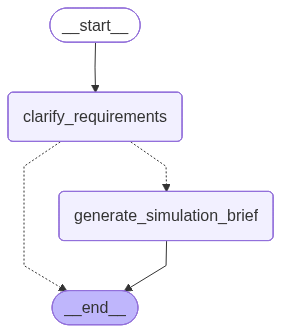

In [28]:
# Import the clarification agent
from mcp_md.clarification_agent import clarification_graph
from langchain_core.messages import HumanMessage

# Visualize the graph
from IPython.display import Image, display
display(Image(clarification_graph.get_graph().draw_mermaid_png()))


### Test Case 1: Incomplete Input (needs clarification)

The agent should ask for more information when given incomplete input.


In [29]:
# Test with incomplete input - should ask for clarification
incomplete_input = {"messages": [HumanMessage(content="I want to run MD simulation")]}

result = clarification_graph.invoke(incomplete_input)
print("=== Test 1: Incomplete Input ===")
print(f"Last message: {result['messages'][-1].content}")


=== Test 1: Incomplete Input ===
Last message: To set up your MD simulation, I need to know:

1. **What is your protein structure source?**
   - PDB ID (e.g., "1AKE")
   - FASTA sequence (for AI structure prediction)
   - Local file path to a PDB/mmCIF file

2. **Is this a soluble protein or a membrane protein?**

3. **Do you have a ligand to include?** (If yes, provide residue name and SMILES string for non-PDB ligands)

Please provide at least the protein source and system type.


### Test Case 2: Complete Input (generates brief)

The agent should proceed to generate a SimulationBrief when given complete information.


In [30]:
# Test with complete input - should generate simulation brief
complete_input = {
    "messages": [
        HumanMessage(content="Please setup MD for PDB 1AKE with aspirin (SMILES: CC(=O)OC1=CC=CC=C1C(=O)O) at pH 7.4")
    ]
}

result = clarification_graph.invoke(complete_input)
print("=== Test 2: Complete Input ===")
print(f"Last message: {result['messages'][-1].content}")
print(f"\nSimulation Brief:")
if result.get("simulation_brief"):
    print(result["simulation_brief"].model_dump_json(indent=2))
else:
    print("No simulation brief generated")


=== Test 2: Complete Input ===
Last message: I have the key information to set up your MD simulation. Before I proceed, I need to clarify a few details:

1. **System type**: Should this be a soluble protein in water, or do you want to embed it in a lipid membrane?

2. **Simulation parameters**: 
   - How long should the simulation run? (default: 1 ns)
   - What ensemble do you prefer: NPT (constant pressure, more realistic) or NVT (constant volume)?
   - Temperature: 300 K is standard, but do you have a preference?

3. **Ligand binding**: Should I dock aspirin to the protein, or do you have a specific binding site in mind? (1AKE is adenylate kinase - aspirin may not be its natural ligand)

4. **Multi-chain handling**: Does 1AKE have multiple chains? Should I include all chains or specific ones?

Simulation Brief:
No simulation brief generated


### Test Case 3: Protein-only simulation (no ligand)

The agent should also handle protein-only simulations without ligands.


In [31]:
# Test with protein-only input
protein_only_input = {
    "messages": [
        HumanMessage(content="Setup MD simulation for PDB 4AKE at 300K with ff19SB force field")
    ]
}

result = clarification_graph.invoke(protein_only_input)
print("=== Test 3: Protein-only Input ===")
print(f"Last message: {result['messages'][-1].content}")
print(f"\nSimulation Brief:")
if result.get("simulation_brief"):
    print(result["simulation_brief"].model_dump_json(indent=2))
else:
    print("No simulation brief generated")


=== Test 3: Protein-only Input ===
Last message: I have the basic setup parameters. To complete the simulation configuration, I need to clarify:

1. **System type**: Is this a soluble protein in water, or a membrane protein? (I'll assume soluble water box if not specified)
2. **Ensemble**: Do you want NPT (constant pressure, more realistic) or NVT (constant volume)? (NPT is recommended for production)
3. **Simulation duration**: How long should the MD run? (default: 1 ns)
4. **Ligands**: Does PDB 4AKE contain any ligands you want to include, or should I remove them?

These choices will affect the solvation setup and simulation parameters.

Simulation Brief:
No simulation brief generated


## Summary

This notebook implemented **Phase 1: Clarification** of the MD setup workflow.

### Next Steps

Continue to **Notebook 2: Setup Agent** to implement Phase 2.


## Summary

This notebook implemented **Phase 1: Clarification** of the MD setup workflow:

1. **State Definitions** (`state_scope.py`)
   - `AgentInputState`: Input schema for user messages
   - `AgentState`: Full state with simulation_brief, decision_log, outputs
   - `ClarifyWithUser`: Schema for clarification decisions
   - `SimulationBrief`: Schema for structured simulation parameters

2. **Prompts** (`prompts.py`)
   - `clarify_requirements_prompt`: Determines if more info needed
   - `generate_simulation_brief_prompt`: Extracts structured parameters

3. **Clarification Agent** (`clarification_agent.py`)
   - `clarify_requirements`: Routes to END (ask user) or `generate_simulation_brief`
   - `generate_simulation_brief`: Creates structured `SimulationBrief`

### Next Steps

Continue to **Notebook 2: Setup Agent** to implement Phase 2 that uses the `SimulationBrief` to execute the MD setup workflow with MCP tools.
